# Exploratory Data Analysis

The main purpose of this notebook is to identify patterns, if any, by means of visualization. Visualizing the data would also help gain a better understanding of it.

In [1]:

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import folium # map rendering library

from geopy.geocoders import Nominatim
from geopy import distance
from pygeocoder import Geocoder

import pickle

print('Libraries imported.')

Libraries imported.


In [21]:
sf_geospatial_data_zip = pd.read_pickle("data/sf_geospatial_data_zip.pkl")
sf_geospatial_data = pd.read_pickle("data/sf_geospatial_data.pkl")
categories = pd.read_pickle("data/categories.pkl")
venues = pd.read_pickle("data/venues.pkl")


In [18]:
print("No. of Neighbouhoods: {}".format(sf_geospatial_data.shape[0]))
print("No. of Postal Codes: {}".format(sf_geospatial_data_zip.shape[0]))
print("No. of Categories: {}".format(categories.shape[0]))
print("No. of Venues: {}".format(venues.shape[0]))

No. of Neighbouhoods: 116
No. of Postal Codes: 27
No. of Categories: 937
No. of Venues: 5549


## Categories

There are a total of 937 categories defined in Foursquare, of which, there are 10 main categories. These main categories are shown below

In [474]:
categories[pd.isnull(categories['parent_id'])]

,name,icon,parent_id
4d4b7104d754a06370d81259,Arts & Entertainment,https://ss3.4sqi.net/img/categories_v2/arts_en...,NaN
4d4b7105d754a06372d81259,College & University,https://ss3.4sqi.net/img/categories_v2/educati...,None
4d4b7105d754a06373d81259,Event,https://ss3.4sqi.net/img/categories_v2/event/d...,None
4d4b7105d754a06374d81259,Food,https://ss3.4sqi.net/img/categories_v2/food/de...,None
4d4b7105d754a06376d81259,Nightlife Spot,https://ss3.4sqi.net/img/categories_v2/nightli...,None
4d4b7105d754a06377d81259,Outdoors & Recreation,https://ss3.4sqi.net/img/categories_v2/parks_o...,None
4d4b7105d754a06375d81259,Professional & Other Places,https://ss3.4sqi.net/img/categories_v2/buildin...,None
4e67e38e036454776db1fb3a,Residence,https://ss3.4sqi.net/img/categories_v2/buildin...,None
4d4b7105d754a06378d81259,Shop & Service,https://ss3.4sqi.net/img/categories_v2/shops/d...,None
4d4b7105d754a06379d81259,Travel & Transport,https://ss3.4sqi.net/img/categories_v2/travel/...,None


In [6]:
'''
These functions help us to find the parent of a category at any level.
'''

'''
Returns a stack of the heirarchy for the specified category
'''
def get_category_heirarchy(categories, category_id, stack=None):
    if stack is None:
        stack = []
    
    stack.append(category_id)
    
    if pd.isnull(categories.loc[category_id, 'parent_id']):
        return stack
    
    return get_category_heirarchy(categories, categories.loc[category_id, 'parent_id'], stack)

'''
Returns the category id at the specified level.
Levels start from 1
'''
def get_category_at_level(categories, category_id, level=1):
    levels = get_category_heirarchy(categories, category_id)
    level_id = ''
    for i in range(0, level):
        if (len(levels) > 0):
            level_id = levels.pop()
        else:
            break
    return level_id

'''
Returns the category name
'''
def get_category_name(categories, category_id):
    return categories.loc[category_id, 'name']

In [65]:
print("An example category heirarchy\n")
heirarchy = get_category_heirarchy(categories, "56aa371be4b08b9a8d5734de")
level = 1
while len(heirarchy) > 0 :
    category_id = heirarchy.pop()
    category_name = get_category_name(categories, category_id)
    tabs = "\t" * (level - 1)
    print("Level: {}{} -> {}".format(level, tabs, category_name))
    level = level + 1

An example category heirarchy

Level: 1 -> Arts & Entertainment
Level: 2	 -> Movie Theater
Level: 3		 -> Drive-in Theater


In [8]:
get_category_name(categories, get_category_at_level(categories, "56aa371be4b08b9a8d5734de", level=2))

'Movie Theater'

## San Francisco by Neighbourhoods

In [16]:
sf_geospatial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 3 columns):
Neighbourhood    116 non-null object
latitude         116 non-null float64
longitude        116 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.8+ KB


In [17]:
sf_geospatial_data.head()

,Neighbourhood,latitude,longitude
0,Seacliff,37.785941,-122.490700
1,Lake Street,37.786197,-122.475521
2,Presidio National Park,37.807044,-122.472101
3,Presidio Terrace,37.788263,-122.460805
4,Inner Richmond,37.779870,-122.464746


In [25]:
san_francisco = r'data/san_francisco.geojson' # geojson file

# create a plain world map
san_francisco_map = folium.Map(location=[37.775420706711, -122.403404791479], zoom_start=12)
san_francisco_map.choropleth(
    geo_data=san_francisco,
    fill_opacity=0.1, 
    line_opacity=1,
    reset =True
)

# add markers to map
for lat, lng, neighborhood in zip(sf_geospatial_data['latitude'], sf_geospatial_data['longitude'], sf_geospatial_data['Neighbourhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(san_francisco_map) 

san_francisco_map

/home/elson/anaconda3/lib/python3.6/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## San Francisco by Postal Codes

In [22]:
sf_geospatial_data_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
postal_code    27 non-null object
latitude       27 non-null float64
longitude      27 non-null float64
dtypes: float64(2), object(1)
memory usage: 728.0+ bytes


In [23]:
sf_geospatial_data_zip.head()

,postal_code,latitude,longitude
0,94124,37.730417,-122.384425
1,94127,37.734646,-122.463708
2,94131,37.740104,-122.438231
3,94133,37.805989,-122.409915
4,94132,37.718140,-122.486349


In [24]:
san_francisco = r'data/san_francisco_zip.geojson' # geojson file

# create a plain world map
san_francisco_map = folium.Map(location=[37.775420706711, -122.403404791479], zoom_start=12)
san_francisco_map.choropleth(
    geo_data=san_francisco,
    fill_opacity=0.1, 
    line_opacity=1,
    reset =True
)

# add markers to map
for lat, lng, neighborhood in zip(sf_geospatial_data_zip['latitude'], sf_geospatial_data_zip['longitude'], sf_geospatial_data_zip['postal_code']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(san_francisco_map) 

san_francisco_map

/home/elson/anaconda3/lib/python3.6/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Venues

In [38]:
venues.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5549 entries, 4f3709abe4b0aa62a1d35520 to 528c2945498ed98d2451a535
Data columns (total 13 columns):
address                 5263 non-null object
category                5549 non-null object
city                    5536 non-null object
country                 5549 non-null object
cross_street            4107 non-null object
lat                     5549 non-null float64
lng                     5549 non-null float64
name                    5549 non-null object
postal_code             5549 non-null object
state                   5549 non-null object
category_name           5549 non-null object
parent_category         5549 non-null object
parent_category_name    5549 non-null object
dtypes: float64(2), object(11)
memory usage: 606.9+ KB


In [39]:
venues.head()

,address,category,city,country,cross_street,lat,lng,name,postal_code,state,category_name,parent_category,parent_category_name
venue_id,,,,,,,,,,,,,
4f3709abe4b0aa62a1d35520,748 Innes Ave,4bf58dd8d48988d1ed941735,San Francisco,United States,NaN,37.730525,-122.372998,Archimedes Banya,94124,CA,Spa,4bf58dd8d48988d1ed941735,Spa
49d3e08bf964a5201f5c1fe3,1634 Jerrold Ave,4bf58dd8d48988d11b951735,San Francisco,United States,NaN,37.739589,-122.390171,Flora Grubb Gardens,94124,CA,Flower Shop,4bf58dd8d48988d11b951735,Flower Shop
53058fdb498e2837542f7f8f,1439 Egbert Ave Unit c,4e0e22f5a56208c4ea9a85a0,San Francisco,United States,3rd Street,37.723004,-122.393615,Seven Stills Brewery & Distillery,94124,CA,Distillery,4e0e22f5a56208c4ea9a85a0,Distillery
555e58ad498e9137bc49f191,900 Marin St,4bf58dd8d48988d1e5931735,San Francisco,United States,btwn Illinois & Michigan St,37.749404,-122.386016,The Midway SF,94124,CA,Music Venue,4bf58dd8d48988d1e5931735,Music Venue
56eb4e0a498e5769545c1843,1525 Cortland Ave,50327c8591d4c4b30a586d5d,San Francisco,United States,NaN,37.739798,-122.408986,Barebottle Brewing Company,94110,CA,Brewery,50327c8591d4c4b30a586d5d,Brewery


## San Francisco by Veneus

In [40]:
venues_in_sf = venues[venues['city'] == 'San Francisco']
print("There are {} venues in San Francisco".format(len(venues_in_sf)))

There are 5509 venues in San Francisco


In [66]:
venue_count = venues_in_sf[['postal_code', 'name']].groupby(by='postal_code').count()

venue_count.reset_index(inplace=True, drop=False)
venue_count.columns = ['zip_code','count']

san_francisco = r'data/san_francisco_zip.geojson' # geojson file

# create a plain world map
san_francisco_map = folium.Map(location=[37.775420706711, -122.403404791479], zoom_start=12)
san_francisco_map.choropleth(
    geo_data=san_francisco,
    data=venue_count,
    columns=['zip_code','count'],
    key_on='feature.properties.zip_code',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=1,
    legend_name='No. of Venues in San Francisco',
    reset =True
)

# add markers to map
'''
for lat, lng, neighborhood in zip(sf_geospatial_data_zip['latitude'], sf_geospatial_data_zip['longitude'], sf_geospatial_data_zip['postal_code']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(san_francisco_map) 
'''

san_francisco_map

/home/elson/anaconda3/lib/python3.6/site-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Venues in San Francisco by Category

In [56]:
categories_in_sf = venues_in_sf[['category']]
print('There are {} different venue categories in San Francisco'.format(len(categories_in_sf['category'].unique())))

There are 397 different venue categories in San Francisco


In [58]:
categories_in_sf['main_category'] = categories_in_sf['category'].apply(lambda cat_id: get_category_name(categories, get_category_at_level(categories, cat_id, level=1)))

/home/elson/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [59]:
categories_in_sf.head()

,category,main_category
venue_id,,
4f3709abe4b0aa62a1d35520,4bf58dd8d48988d1ed941735,Shop & Service
49d3e08bf964a5201f5c1fe3,4bf58dd8d48988d11b951735,Shop & Service
53058fdb498e2837542f7f8f,4e0e22f5a56208c4ea9a85a0,Professional & Other Places
555e58ad498e9137bc49f191,4bf58dd8d48988d1e5931735,Arts & Entertainment
56eb4e0a498e5769545c1843,50327c8591d4c4b30a586d5d,Nightlife Spot


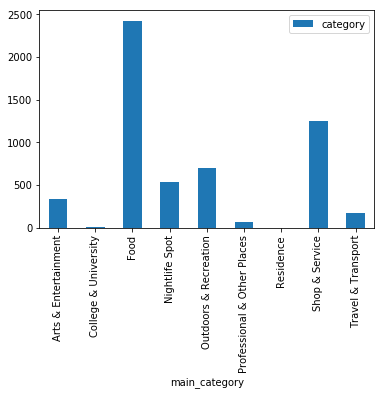

In [64]:
categories_in_sf.groupby(by='main_category').count().plot(kind='bar')
plt.show()

## Next Venues

In [9]:
next_venues = pd.read_pickle('data/next_venues.pkl')

In [10]:
next_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19494 entries, 0 to 19493
Data columns (total 5 columns):
venue_id               19494 non-null object
next_venue_id          19494 non-null object
venue_category         19494 non-null object
next_venue_category    19494 non-null object
distance               19494 non-null float64
dtypes: float64(1), object(4)
memory usage: 761.6+ KB


In [11]:
next_venues.head()

,venue_id,next_venue_id,venue_category,next_venue_category,distance
0,4f3709abe4b0aa62a1d35520,43c4e03ff964a5205d2d1fe3,Spa,Brewery,1.122189
1,49d3e08bf964a5201f5c1fe3,46363302f964a52012461fe3,Flower Shop,Coffee Shop,0.003798
2,49d3e08bf964a5201f5c1fe3,4f833c3be4b0e533af027908,Flower Shop,Pizza Place,0.100066
3,49d3e08bf964a5201f5c1fe3,4bd4afdb29eb9c744a2892e1,Flower Shop,Garden Center,1.506962
4,49d3e08bf964a5201f5c1fe3,4bf313f7370e76b0c956bd4a,Flower Shop,Dessert Shop,2.038199


In [21]:
next_venues[next_venues['distance'] < 1]['distance'].hist()

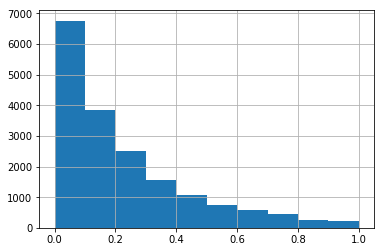

In [22]:
plt.show()

In [25]:
next_venues[next_venues['distance'] < 0.5].shape

(15735, 5)

In [29]:
table = pd.pivot_table(next_venues, index='venue_category', columns='next_venue_category', aggfunc=np.size)

In [30]:
table.head()

distance                                         \
next_venue_category Adult Boutique African Restaurant American Restaurant   
venue_category                                                              
Adult Boutique                 NaN                NaN                 NaN   
Afghan Restaurant              NaN                NaN                 NaN   
African Restaurant             NaN                NaN                 1.0   
American Restaurant            NaN                NaN                15.0   
Amphitheater                   NaN                NaN                 1.0   

                                                              \
next_venue_category Antique Shop Aquarium Arcade Art Gallery   
venue_category                                                 
Adult Boutique               NaN      NaN    NaN         NaN   
Afghan Restaurant            NaN      NaN    NaN         NaN   
African Restaurant           NaN      NaN    NaN         NaN   
American Restaurant          NaN      NaN    1.0         2.0   
Amphitheater                 NaN      NaN    NaN         NaN   

                                                                             \
next_venue_category Arts & Crafts Store Asian Restaurant Athletics & Sports   
venue_category                                                                
Adult Boutique                      NaN              NaN                NaN   
Afghan Restaurant                   NaN              NaN                NaN   
African Restaurant                  NaN              NaN                NaN   
American Restaurant                 NaN              4.0                3.0   
Amphitheater                        NaN              1.0                NaN   

                                                                         \
next_venue_category Austrian Restaurant BBQ Joint Baby Store Bagel Shop   
venue_category                                                            
Adult Boutique                      NaN       NaN        NaN        NaN   
Afghan Restaurant                   NaN       NaN        NaN        NaN   
African Restaurant                  NaN       NaN        NaN        NaN   
American Restaurant                 NaN       NaN        NaN        NaN   
Amphitheater                        NaN       NaN        NaN        NaN   

                                                                               \
next_venue_category Bakery Bank    Bar Beach Belgian Restaurant Big Box Store   
venue_category                                                                  
Adult Boutique         1.0  NaN    5.0   NaN                NaN           1.0   
Afghan Restaurant      NaN  NaN    2.0   NaN                NaN           NaN   
African Restaurant     NaN  NaN    7.0   NaN                NaN           NaN   
American Restaurant    5.0  NaN  147.0   6.0                NaN           NaN   
Amphitheater           NaN  NaN    NaN   NaN                NaN           NaN   

                                                                  \
next_venue_category Bike Shop Board Shop Boat or Ferry Bookstore   
venue_category                                                     
Adult Boutique            NaN        NaN           NaN       NaN   
Afghan Restaurant         NaN        NaN           NaN       NaN   
African Restaurant        NaN        NaN           NaN       NaN   
American Restaurant       NaN        NaN           1.0       3.0   
Amphitheater              NaN        NaN           NaN       NaN   

                                                                           \
next_venue_category Botanical Garden Bowling Alley Breakfast Spot Brewery   
venue_category                                                              
Adult Boutique                   NaN           NaN            NaN     NaN   
Afghan Restaurant                NaN           NaN            NaN     NaN   
African Restaurant               NaN           NaN            NaN     NaN   
Americ

In [34]:
next_venues[(next_venues['venue_category'] == 'American Restaurant') & (next_venues['next_venue_category'] == 'Dessert Shop')]

,venue_id,next_venue_id,venue_category,next_venue_category,distance
364,4be39634b02ec9b68f0f50c0,49972b39f964a52089521fe3,American Restaurant,Dessert Shop,0.551307
404,3fd66200f964a520a0ec1ee3,45eaff58f964a5208e431fe3,American Restaurant,Dessert Shop,0.796088
426,40e0b100f964a520e2091fe3,49972b39f964a52089521fe3,American Restaurant,Dessert Shop,0.866363
1151,4b00cb8ef964a520274122e3,45eaff58f964a5208e431fe3,American Restaurant,Dessert Shop,0.586528
1564,500088f7d63e64b62bc19e6e,4d964291daec224b08b9123e,American Restaurant,Dessert Shop,0.202386
2217,55319ec2498ee038ee77c144,58ec10b1fbe8ff51800668de,American Restaurant,Dessert Shop,0.667200
3208,4faaba890cd6e74f6f96bab1,49972b39f964a52089521fe3,American Restaurant,Dessert Shop,0.720970
3548,3fd66200f964a520d0ec1ee3,4a039807f964a520d1711fe3,American Restaurant,Dessert Shop,0.298049
5505,539803d6498e0283d6b81896,57784c4b498e532e84e77f3f,American Restaurant,Dessert Shop,0.113275
5507,539803d6498e0283d6b81896,52ba6597498e53bfd973e0eb,American Restaurant,Dessert Shop,0.291234
